In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tmfc_py.bold_deconvolution import ridge_regress_deconvolution
from gppi_regressors_utils import create_raw_psych_regressor, create_ppi_regressor
import pandas as pd
from pathlib import Path
from bold_deconvolution import ridge_regress_deconvolution



In [2]:
VOI_SPM = Path.cwd().parent / 'data' / 'external' / '01_Sub' / 'VOIs' / 'VOI_001_L_V1_1.mat'
PPI_SPM_GO = Path.cwd().parent / 'data' / 'external' / '01_Sub' / 'PPIs' / 'PPI_[001_L_V1]_[Sess_1]_[Cond_1]_[GO].mat'
PPI_SPM_STOP_CORRECT = Path.cwd().parent / 'data' / 'external' / '01_Sub' / 'PPIs' / 'PPI_[001_L_V1]_[Sess_1]_[Cond_2]_[STOP_CORRECT].mat'
PPI_SPM_STOP_INCORRECT = Path.cwd().parent / 'data' / 'external' / '01_Sub' / 'PPIs' / 'PPI_[001_L_V1]_[Sess_1]_[Cond_3]_[STOP_INCORR].mat'

EVENTS_PATH = Path.cwd().parent /'data'/'raw'/ '01_Sub' / 'sots'/'02_Run_06_Deriv_[fix_onset]_[700ms_dur].csv'

In [3]:
voi = sio.loadmat(str(VOI_SPM))['Y'].squeeze()
ppi_spm_go = sio.loadmat(str(PPI_SPM_GO),  struct_as_record=False)
#ppi_spm_stop_correct = sio.loadmat(str(PPI_SPM_STOP_CORRECT))['PPI'].squeeze()
#ppi_spm_stop_incorr = sio.loadmat(str(PPI_SPM_STOP_INCORRECT))['PPI'].squeeze()


In [4]:
np.mean(ppi_spm_go['PPI'][0,0].P)

np.float64(0.2209893123695098)

In [7]:
ppi_spm_go['PPI'][0,0].xn.shape

(7392, 1)

Text(0.5, 1.0, 'PsyOnsets')

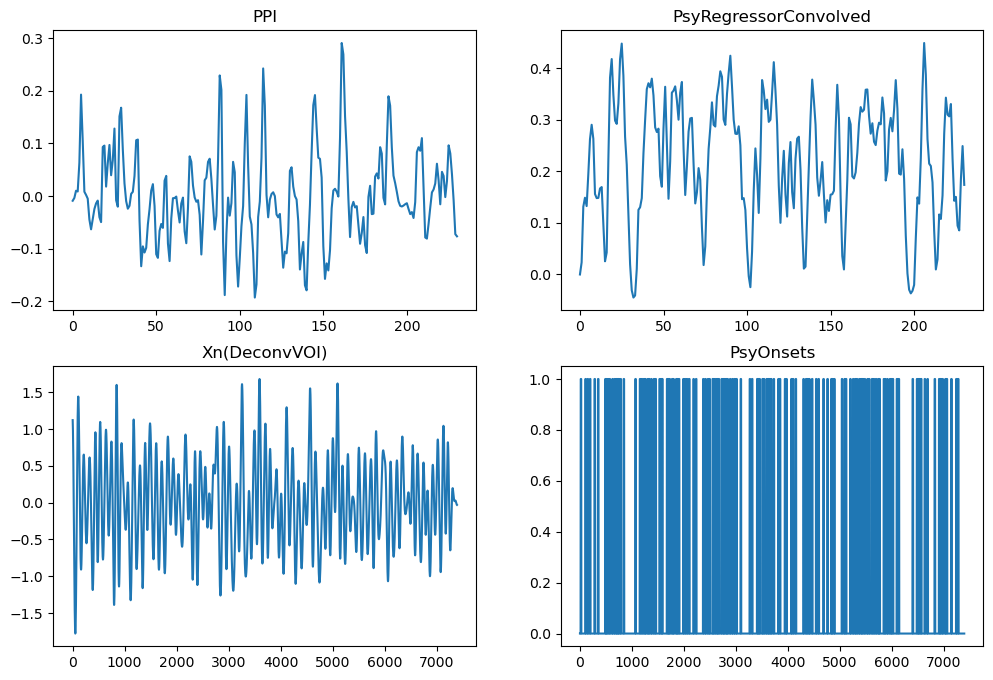

In [8]:
fig, axes = plt.subplots(2,2, figsize=(12, 8))
axes[0,0].plot(ppi_spm_go['PPI'][0,0].ppi); axes[0,0].set_title('PPI')
axes[0,1].plot(ppi_spm_go['PPI'][0,0].P); axes[0,1].set_title('PsyRegressorConvolved')
axes[1,0].plot(ppi_spm_go['PPI'][0,0].xn); axes[1,0].set_title('Xn(DeconvVOI)')
axes[1,1].plot(ppi_spm_go['PPI'][0, 0].psy[0,0].u.toarray()); axes[1,1].set_title('PsyOnsets')



In [86]:
psy_reg_spm = ppi_spm_go['PPI'][0, 0].psy[0,0].u.toarray().squeeze()

In [20]:
events_df = pd.read_csv(str(EVENTS_PATH), sep='\t')
psy_reg = create_raw_psych_regressor(events_df, 'GO', 231, 2, 32)
#voi_bold = sio.loadmat(str(VOI_SPM))['Y'].squeeze()
voi_bold =ppi_spm_go['PPI'][0,0].Y.squeeze()

neural_signal = ridge_regress_deconvolution(
        BOLD=voi_bold,
        TR=2,
        NT=32
    )
ppi_regressor = create_ppi_regressor(
            voi_bold=voi_bold,
            events_df=events_df,
            task_name='GO',
            tr=2.0,
            microtime_resolution=32,
            demean=False
        )

In [21]:
neural_signal.shape, ppi_spm_go['PPI'][0,0].xn.shape

((7392,), (7392, 1))

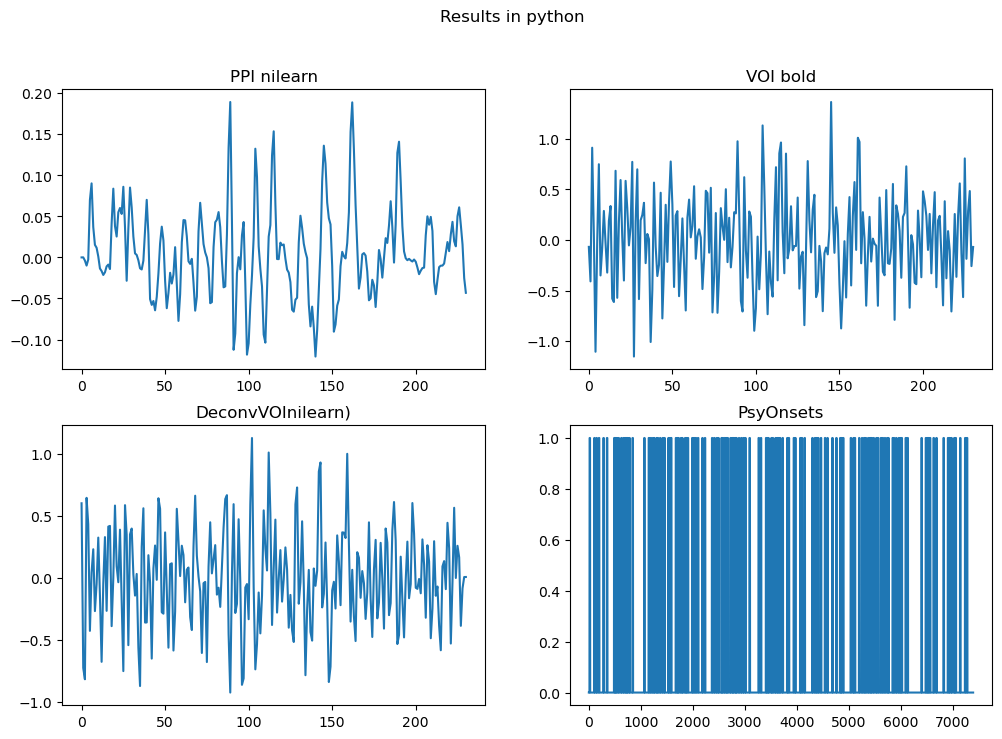

In [22]:
fig, axes = plt.subplots(2,2, figsize=(12, 8))
axes[0,0].plot(ppi_regressor); axes[0,0].set_title('PPI nilearn')
axes[0,1].plot(voi_bold); axes[0,1].set_title('VOI bold')
axes[1,0].plot(neural_signal[::32]); axes[1,0].set_title('DeconvVOInilearn)')
axes[1,1].plot(psy_reg); axes[1,1].set_title('PsyOnsets')
fig.suptitle("Results in python");



In [23]:
corr_neuro = np.corrcoef(ppi_spm_go['PPI'][0,0].xn.squeeze(), neural_signal)[0,1]
corr_ppi = np.corrcoef(ppi_spm_go['PPI'][0,0].ppi.squeeze(), ppi_regressor)[0,1]
print(f"Correlation of deconvolved {corr_neuro :.2f} and correlation between ppis {corr_ppi :.2f}")

Correlation of deconvolved 0.96 and correlation between ppis 0.91


In [27]:
ppi_regressor_zero_psy = create_ppi_regressor(
            voi_bold=voi_bold,
            events_df=events_df,
            task_name='GO',
            tr=2.0,
            microtime_resolution=32,
            demean=True
        )
ppi_regressor = create_ppi_regressor(
    voi_bold=voi_bold,
    events_df=events_df,
    task_name='GO',
    tr=2.0,
    microtime_resolution=32,
    demean=False
)

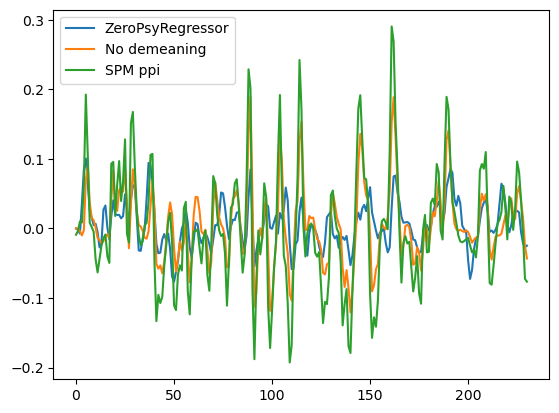

In [30]:
plt.plot(ppi_regressor_zero_psy, label='ZeroPsyRegressor')
plt.plot(ppi_regressor, label='No demeaning')
plt.plot(ppi_spm_go['PPI'][0,0].ppi.squeeze(), label='SPM ppi')
plt.legend()